# 2. Cleaning and EDA

#### Alfredo Di Massimo

#### BrainStation, Data Science

#### April 4th, 2022

___

The goal of this notebook will be to clean, analyze and prepare the data in order to be able to fit it to our machine learning models. We will further explore such questions as:
- What statistical insight can we gather?
- What is the distribution of the different genres?
- What are some common words used in reviews to gain a high-level understanding of what's important to consumers?

We can begin by importing basic libraries that will be used:

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# visualization packages
import seaborn as sns
from wordcloud import WordCloud

# text data & preprocessing packages
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

# utility packages
import joblib

In [3]:
# Load in the data
movies_base = joblib.load('movies_base.pkl')
movies_base.head()

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,review,review_rating,review_word_count
0,tt0003419,The Student of Prague,1913,85,"Drama,Fantasy,Horror",6.5,2054,"A good film, and one I'll watch a number of ti...",8,172
1,tt0003419,The Student of Prague,1913,85,"Drama,Fantasy,Horror",6.5,2054,"In this truly fascinating, dark film, a young ...",10,292
2,tt0003419,The Student of Prague,1913,85,"Drama,Fantasy,Horror",6.5,2054,This early version of the tale 'The Student of...,7,142
3,tt0003419,The Student of Prague,1913,85,"Drama,Fantasy,Horror",6.5,2054,Those engaging the movie camera so early in th...,7,165
4,tt0003419,The Student of Prague,1913,85,"Drama,Fantasy,Horror",6.5,2054,A stupid young man becomes obsessed with a wom...,8,184


Given the `movies` dataset was constructed by performing inner joins on datasets containing information from the same source, very minimal cleaning will be required. This will begin by checking the dataset for duplicate and null values.

In [4]:
print(f'There are {movies_base.shape[0]} rows in the movies dataset.')
print(f'There are {movies_base.shape[1]} columns in the movies dataset.')
print(f'There are {movies_base.isnull().sum().sum()} null values in the movies dataset.')
print(f'There are {movies_base.duplicated().sum()} duplicate rows in the movies dataset.')

There are 25129 rows in the movies dataset.
There are 10 columns in the movies dataset.
There are 4 null values in the movies dataset.
There are 40 duplicate rows in the movies dataset.


In [5]:
movies_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25129 entries, 0 to 25128
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             25129 non-null  object 
 1   primaryTitle       25129 non-null  object 
 2   startYear          25129 non-null  object 
 3   runtimeMinutes     25125 non-null  object 
 4   genres             25129 non-null  object 
 5   averageRating      25129 non-null  float64
 6   numVotes           25129 non-null  int64  
 7   review             25129 non-null  object 
 8   review_rating      25129 non-null  int64  
 9   review_word_count  25129 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 2.1+ MB


**Observations**:
- Prior to converting the **runtimeMinutes** column from string to int, we will need to handle a couple of null values;
- **tconst** to be dropped as it provides no insight, served only to merge datasets in previous notebook;
- **startYear** will need to be converted to a numeric column as it currently contains the production year for a movie as a string.

##### Dropping `tconst`

In [6]:
movies_base.drop(columns='tconst', inplace=True)
movies_base.columns

Index(['primaryTitle', 'startYear', 'runtimeMinutes', 'genres',
       'averageRating', 'numVotes', 'review', 'review_rating',
       'review_word_count'],
      dtype='object')

##### Converting `startYear`

In [7]:
movies_base['startYear'] = movies_base['startYear'].astype(int)

#convfirm successful conversion to int
movies_base['startYear'].dtypes

dtype('int32')

### Duplicate Values

Given there are only 40 duplicates in our dataset of 25,129 rows, we can proceed with dropping them as the reviews denote that each row should be unique without any repeating reviews.

In [8]:
# Dropping duplicates
movies = movies_base.drop_duplicates()
movies.duplicated().sum()

0

### Null Values

We can proceed with cleaning the data by analyzing the null values and handle them accordingly.

In [9]:
# Get a clear idea of how many nulls are in each column
movies.isnull().sum()

primaryTitle         0
startYear            0
runtimeMinutes       4
genres               0
averageRating        0
numVotes             0
review               0
review_rating        0
review_word_count    0
dtype: int64

##### runtime Minutes

Given that there are only 4 null values from the **runtimeMinutes** column, we can call the specific rows and manually look up the movie runtimes.

In [10]:
movies[movies['runtimeMinutes'].isna()]

,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,review,review_rating,review_word_count
11090,Lethal Panther 2,1993,NaN,Action,5.0,68,"Set in the Philipines, Lethal Panther 2 is a d...",3,177
19939,Dress to Kill,2007,NaN,"Crime,Drama,Romance",4.2,131,Everyone knows that late night movies aren't O...,1,228
19940,Dress to Kill,2007,NaN,"Crime,Drama,Romance",4.2,131,There are some great Canadian films. There are...,1,494
19941,Dress to Kill,2007,NaN,"Crime,Drama,Romance",4.2,131,What can be said about a movie about a cross d...,1,197


There are actually only 2 movies to search for here, *Lethal Panther 2* and *Dress to Kill*. Having found the runtime for each of the movies, we can replace the null values with the appropriate runtime in minutes for each.

In [11]:
# Using the .loc() method to specify the runtime for the movie 'Lethal Panther 2'
movies.loc[10055, 'runtimeMinutes'] = 105

C:\Users\Alfredo\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [12]:
#Confirming the runtime for 'Lethal Panther 2' was successfully filled in
movies[movies['runtimeMinutes'].isna()]

,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,review,review_rating,review_word_count
11090,Lethal Panther 2,1993,NaN,Action,5.0,68,"Set in the Philipines, Lethal Panther 2 is a d...",3,177
19939,Dress to Kill,2007,NaN,"Crime,Drama,Romance",4.2,131,Everyone knows that late night movies aren't O...,1,228
19940,Dress to Kill,2007,NaN,"Crime,Drama,Romance",4.2,131,There are some great Canadian films. There are...,1,494
19941,Dress to Kill,2007,NaN,"Crime,Drama,Romance",4.2,131,What can be said about a movie about a cross d...,1,197


In [13]:
# We can specify the runtime for the remaining null values given they correspond to the same movie
movies['runtimeMinutes'].fillna(120, inplace=True)

C:\Users\Alfredo\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [14]:
# Confirm there are no remaining null values in the runtimeMinutes column
movies['runtimeMinutes'].isna().sum()

0

With this, we can proceed with converting the **runtimeMinutes** to an integer column.

In [15]:
movies['runtimeMinutes'] = movies['runtimeMinutes'].astype(int)

#convfirm successful conversion to int
movies['runtimeMinutes'].dtypes

C:\Users\Alfredo\AppData\Local\Temp/ipykernel_15404/774934602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['runtimeMinutes'] = movies['runtimeMinutes'].astype(int)


dtype('int32')

## Inspecting the Data

With the dataset cleaned, we can now explore the data to gain some preliminary insights.

In [16]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25089 entries, 0 to 25128
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primaryTitle       25089 non-null  object 
 1   startYear          25089 non-null  int32  
 2   runtimeMinutes     25089 non-null  int32  
 3   genres             25089 non-null  object 
 4   averageRating      25089 non-null  float64
 5   numVotes           25089 non-null  int64  
 6   review             25089 non-null  object 
 7   review_rating      25089 non-null  int64  
 8   review_word_count  25089 non-null  int64  
dtypes: float64(1), int32(2), int64(3), object(3)
memory usage: 2.2+ MB


With the intention of this analysis being to predict whether a movie is considered "good" or "bad" based on a review, having two columns that represent the rating is somewhat redundant. As such, we will proceed with dropping the **averageRating** column as it only provides the average rating a movie receives and would not be a representative target variable for our analysis. The the **review_rating** will be a more appropriate target variable to use when training our models as it is a direct measure of a reviewer's sentiment when rating a movie.

In [17]:
movies.drop(columns='averageRating', inplace=True)

C:\Users\Alfredo\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
movies.head()

,primaryTitle,startYear,runtimeMinutes,genres,numVotes,review,review_rating,review_word_count
0,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,"A good film, and one I'll watch a number of ti...",8,172
1,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,"In this truly fascinating, dark film, a young ...",10,292
2,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,This early version of the tale 'The Student of...,7,142
3,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,Those engaging the movie camera so early in th...,7,165
4,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,A stupid young man becomes obsessed with a wom...,8,184


For a more efficient way of working through the columns and clean/preprocessing our dataset, store the numeric and non-numeric features into lists.

In [19]:
numeric_col_list = list(movies.select_dtypes('number').columns)

categorical_col_list = list(movies.select_dtypes('object').columns)

print(numeric_col_list)
print(categorical_col_list)

['startYear', 'runtimeMinutes', 'numVotes', 'review_rating', 'review_word_count']
['primaryTitle', 'genres', 'review']


We can review some basic statistical information as well as the distributions for our numeric columns first:

In [20]:
movies.describe().T

,count,mean,std,min,25%,50%,75%,max
startYear,25089.0,1988.959185,18.563284,1913.0,1980.0,1996.0,2003.0,2010.0
runtimeMinutes,25089.0,105.280960,21.871664,47.0,92.0,101.0,114.0,422.0
numVotes,25089.0,47385.016422,119808.653548,47.0,3134.0,10562.0,37037.0,1963908.0
review_rating,25089.0,5.762765,3.397213,1.0,2.0,7.0,9.0,10.0
review_word_count,25089.0,244.117063,183.728138,6.0,127.0,181.0,303.0,2278.0


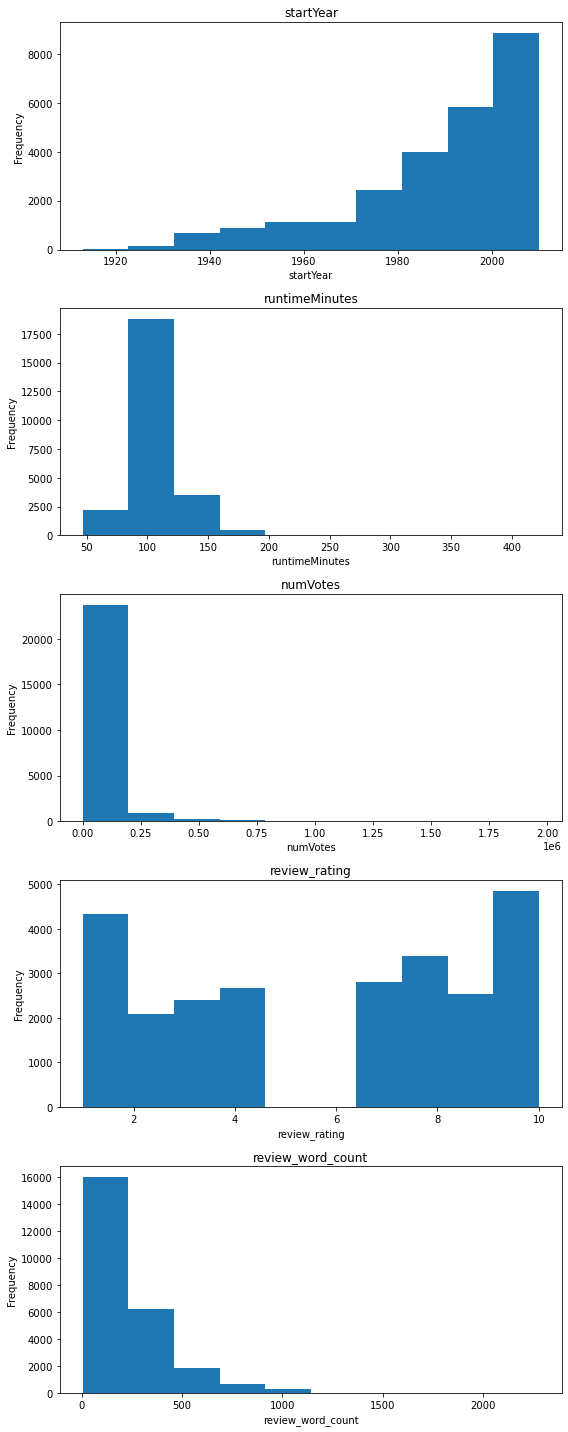

In [21]:
plt.subplots(5,1, figsize=(8,20))

for i, col in enumerate(movies[numeric_col_list].columns):
    plt.subplot(5,1,i+1)
    plt.hist(movies[numeric_col_list][col])
    
    # Label my graph
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
plt.tight_layout()    
plt.show()

**Observations**:
- Not all years appear to be represented equally in the dataset with a strong upward trend of leaving reviews for films tha were produced beginning in the late 1960's. Additional data on the users would allow for further exploration of a correlation between the reviewer's age and possible willingness to provide a review on a film;
- The **runtimeMinutes** is heavily right-skewed indicating that the majority of films reviewed are about an hour and a half;
- The **numVotes** columns presents with a significantly spread out distribution of values with the min number of votes being 51 for a movie and the maximum being 1,963,908; this may serve as a proxy for a movie's popularity to be explored later;
- The **review_rating** presents an interesting bi-modal distribution with the highest frequencies of ratings being towards the extremes of both the postive and negative score brackets. This is somewhat expected based on the notion that individuals who would leave a review are more likely to do so because they either strongly disliked or liked a movie. ***NOTE*** The chart does not display any individual review scores between 4-7 as noted in the data dictionary found in the `Data Merging` notebook, because reviews were only classified as negative and positive if they were given as score of 1-4 and 7-10 respectively.
- The **review_word_count** has a right-skewed distribution, demonstrating that the majority of reviews will tend to be shorter than longer with average word counts of about 245 words.

We can quickly explore the relationship between the different variables in our dataset by using a seaborn pairplot.

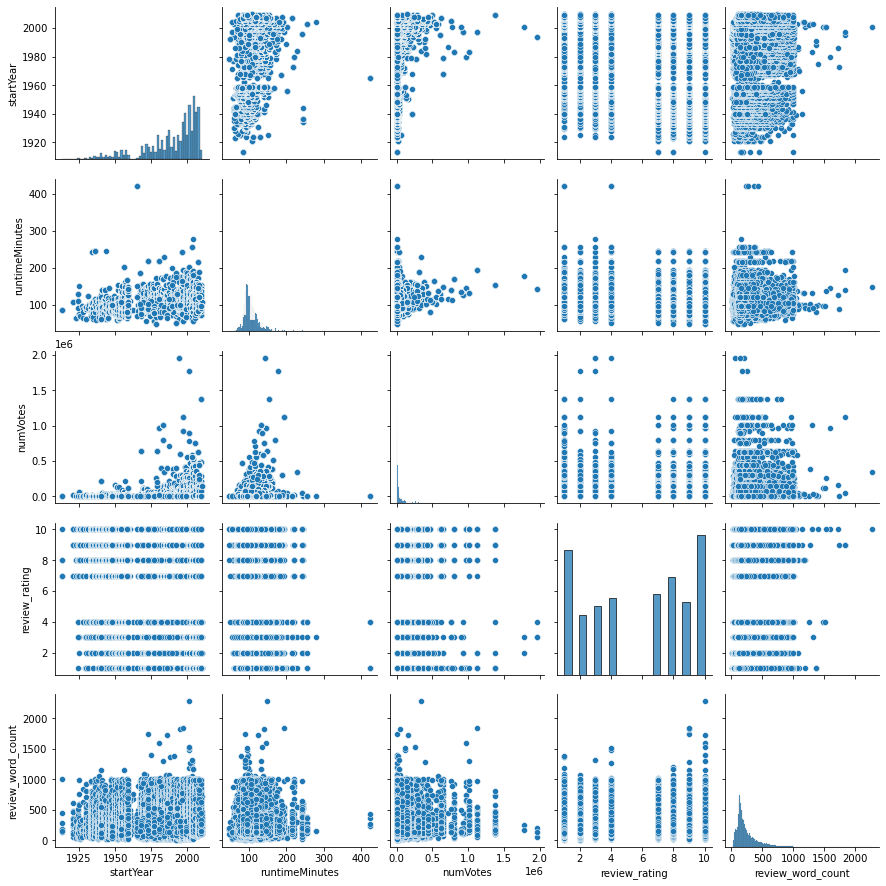

In [22]:
sns.pairplot(movies[numeric_col_list])
plt.show()

A quick analysis of the scatterplots does not reveal any strong linear relationships between the variables. Some variables do however exhibit interesting patterns due to their discrete nature.

We can also determine whether any of the variables have strong correlations to one another by plotting a heat map with the correlation coefficients.

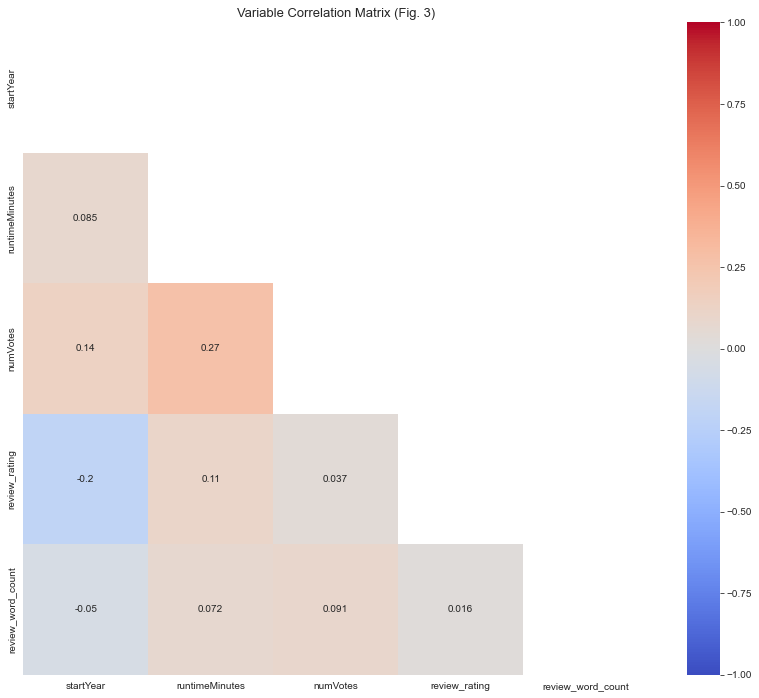

In [23]:
#format plot
sns.set_style('whitegrid')
plt.figure(figsize=(14,12))

matrix = np.triu(movies.corr())

#create heatmap
sns.heatmap(movies.corr(), mask=matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

#generate plot
plt.title('Variable Correlation Matrix (Fig. 3)', fontsize=13)
plt.show()

We can determine whether these are statistically significant relationships be assessing their individual p-values with a threshhold of 0.05; a lower p-value would make the relationship statistically significant. The target variable for these tests will be the **averageRating**.

In [24]:
for feature in ['startYear', 'runtimeMinutes', 'numVotes', 'review_word_count']:
    r = stats.pearsonr(movies['review_rating'], movies[feature])[0]
    p = stats.pearsonr(movies['review_rating'], movies[feature])[1]
    print(f"Feature: {feature} ... r={r}...p={p}")
          
num_variable = movies[['review_rating', 'startYear', 'runtimeMinutes', 'numVotes', 'review_word_count']]
          
num_variable.corr().style.background_gradient('coolwarm')    

Feature: startYear ... r=-0.19862014807344783...p=1.3909111821476296e-221
Feature: runtimeMinutes ... r=0.10874503408554037...p=7.248711445531261e-67
Feature: numVotes ... r=0.03700514084711948...p=4.54172855550492e-09
Feature: review_word_count ... r=0.015794655633222694...p=0.012355425855554327


,review_rating,startYear,runtimeMinutes,numVotes,review_word_count
review_rating,1.000000,-0.198620,0.108745,0.037005,0.015795
startYear,-0.198620,1.000000,0.085321,0.137045,-0.049742
runtimeMinutes,0.108745,0.085321,1.000000,0.272849,0.071980
numVotes,0.037005,0.137045,0.272849,1.000000,0.090776
review_word_count,0.015795,-0.049742,0.071980,0.090776,1.000000


**Observations**
- There also seems to be a similar relationship between **numVotes** and **runtimeMinutes**, implying that longer movies may possess a higher number of votes.
- A mildly negative relationship can be seen between the individual **review_rating** column and the **startYear** can be further explored to determine whether older movies receive higher ratings.

___

## Analysis and Preprocessing

This section will look to further analyze and preprocess the data in order to be able to fit it to machine learning models later. 

### `review_rating`

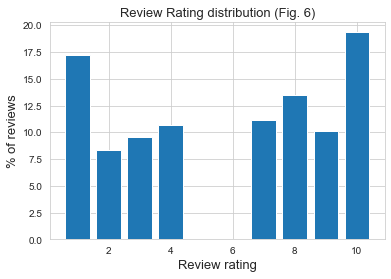

In [25]:
values, counts = np.unique(movies['review_rating'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review rating', fontsize=13)
plt.ylabel('% of reviews', fontsize=13)
plt.title("Review Rating distribution (Fig. 6)", fontsize=13)
plt.show()

We can proceed by defining our *target variable* as a new column that we will create: **sentiment**. This will be used to measure a movie's success and as such, using the reviews left by movie-goers, we will aim to predict whether a movie is "bad" (0) or "good" (1). It will essentially bin the **reviewer_rating** column into categories for a higher level of accuracy in our initial model trainings.

In [26]:
# We can use the np.where() method to classify a movie as "bad" or "good" based on the rounded down mean for 'averageRating'
movies['sentiment'] = np.where(movies['review_rating'] >= 7, 1, 0)
movies.head()

C:\Users\Alfredo\AppData\Local\Temp/ipykernel_15404/2568965644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['sentiment'] = np.where(movies['review_rating'] >= 7, 1, 0)


,primaryTitle,startYear,runtimeMinutes,genres,numVotes,review,review_rating,review_word_count,sentiment
0,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,"A good film, and one I'll watch a number of ti...",8,172,1
1,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,"In this truly fascinating, dark film, a young ...",10,292,1
2,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,This early version of the tale 'The Student of...,7,142,1
3,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,Those engaging the movie camera so early in th...,7,165,1
4,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,A stupid young man becomes obsessed with a wom...,8,184,1


We can move this column towards the beginning of our dataframe next to the **review** column.

In [27]:
# use pop to remove the 'sentiment' column and assign it to a variable
sentiment = movies.pop('sentiment')

# insert the popped column using the .insert(method)
movies.insert(5, 'sentiment', sentiment)

# confirm this shift was done succesfully
movies.head(1)

,primaryTitle,startYear,runtimeMinutes,genres,numVotes,sentiment,review,review_rating,review_word_count
0,The Student of Prague,1913,85,"Drama,Fantasy,Horror",2054,1,"A good film, and one I'll watch a number of ti...",8,172


Because we will be aiming to predict the sentiment value of "good" or "bad" as opposed to the actual **review_Rating**, we can proceed with dropping it from our dataset.

In [28]:
movies.drop(columns='review_rating', inplace=True)

C:\Users\Alfredo\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


___

### startYear

I'm interested in visualizing a more accurate depiction of the distribution of the years in which the movies in our dataset were produced.

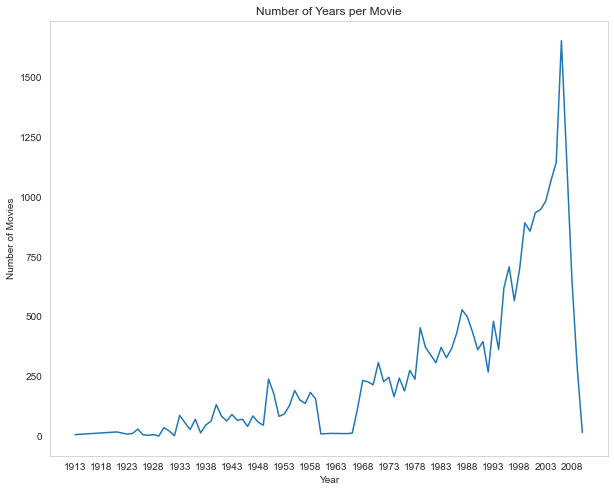

In [29]:
# Plot number of movies per year in dataset
plt.figure(figsize=(10,8))
movies['startYear'].value_counts().sort_index().plot()
plt.title('Number of Years per Movie')
plt.xlabel('Year')
plt.xticks(np.arange(min(movies['startYear']), max(movies['startYear'])+1, 5))
plt.ylabel('Number of Movies')
plt.grid()
plt.show()

As noted in the observations above, we can see in *Figure 1* above that there is a rising trend as of 1967 in the number of reviews left for movies based on their year of production. With IMDb being created in 1990, the accessibility of the sights servies can be explored based on a generational level of its visitors. Additional data can possibly provide an indication into the age groups that are leaving reviews. <br/>
The production year of the movies in our dataset are not fairly represented and because age of a movie would not serve in understanding how present-day directors can gain actionable insights from a review, we can proceed with dropping this column.

In [30]:
movies.drop(columns='startYear', inplace=True)

C:\Users\Alfredo\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


___

### `Review_word_count`

Based on personal experience reading reviews, I expect a review for a "good" movie to have a higher word count than a "bad" one. We can visualize this.

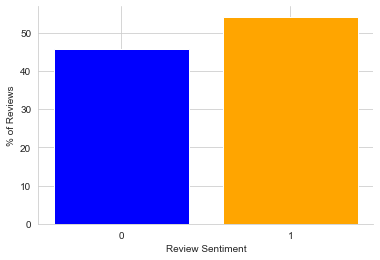

Class imbalance: [0.46 0.54]


In [31]:
values, counts = np.unique(movies['sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100, color=['blue', 'orange']) # plot normalized counts
plt.xlabel('Review Sentiment')
plt.ylabel('% of Reviews')
sns.despine()
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

The distribution is only slightly imbalanced with "good" movies making up a higher proprtion of our dataset. This is noted for the modeling phase in a later notebook.

___

### `Genres`

I would first like to get an idea of the distribution of different movie genres within our dataset.

In [32]:
movies['genres'].nunique()

361

We can see that there are 354 unique groupings because a movie can belong to multiple movie genres. As such, the distribution of these unique groupings may be rather difficult to interpret, but it can give us an idea of how the movies are represented based on the groups of genres.

C:\Users\Alfredo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


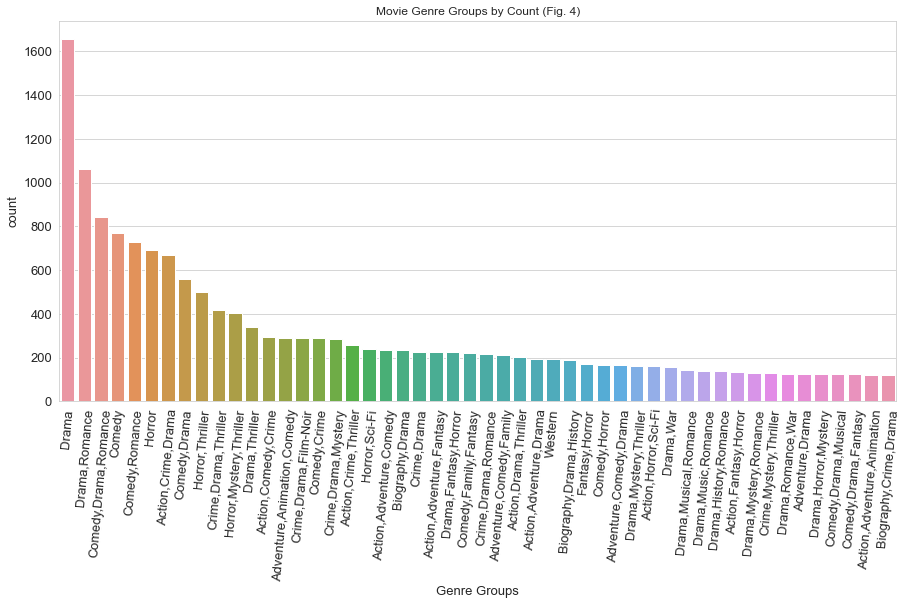

In [33]:
plt.figure(figsize=(15,7))
sns.countplot(movies['genres'], order=movies.genres.value_counts().iloc[:50].index)
plt.xticks(rotation=85, fontsize=13)
plt.xlabel('Genre Groups', fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('count', fontsize=13)
plt.title('Movie Genre Groups by Count (Fig. 4)')
plt.show()

*Figure 4* above demonstrates that dramas make up a considerable majority of the movies within our dataset and that several genres that appear thereafter contain "Drama" as a sub-genre. We can immediately proceed with encoding the multi-genre categories for machine learning models and get a clearer idea of which specific genres appear most often in our dataset.

In [34]:
# Using the commas as a delimiter, we can instantiate a list object for each row
movies['genres'] = movies['genres'].str.split(',')
movies['genres']

C:\Users\Alfredo\AppData\Local\Temp/ipykernel_15404/3914173291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres'] = movies['genres'].str.split(',')


0        [Drama, Fantasy, Horror]
1        [Drama, Fantasy, Horror]
2        [Drama, Fantasy, Horror]
3        [Drama, Fantasy, Horror]
4        [Drama, Fantasy, Horror]
                   ...           
25124                    [Horror]
25125                    [Horror]
25126                    [Horror]
25127                    [Horror]
25128                    [Horror]
Name: genres, Length: 25089, dtype: object

In [35]:
# Create a list of the unique genres to determine how many there are
genre_list = []

for row in movies['genres']:
    for genre in row:
        if genre not in genre_list:
            genre_list.append(genre)
        else:
            continue

print(f"There are {len(genre_list)} unique genres.")
genre_list

There are 24 unique genres.


['Drama',
 'Fantasy',
 'Horror',
 'Comedy',
 'Adventure',
 'Romance',
 'War',
 'History',
 'Thriller',
 'Sport',
 'Western',
 'Musical',
 'Action',
 'Family',
 'Music',
 'Crime',
 'Mystery',
 'Sci-Fi',
 'Film-Noir',
 'Biography',
 'Animation',
 'Documentary',
 'Adult',
 'News']

*NOTE*: There is in fact a distinction between the *musical* and *music* genres according to [IMDb](https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG#):
- **Musical**: Should contain several scenes of characters bursting into song aimed at the viewer (this excludes songs performed for the enjoyment of other characters that may be viewing) while the rest of the time, usually but not exclusively, portraying a narrative that alludes to another Genre.
- **Music**: Contains significant music-related elements while not actually being a Musical; this may mean a concert, or a story about a band (either fictional or documentary).

WIth the uniqe genres identified and separated within the **genres** column, we can now use SKLearns *MultiLabelBinarizer* to create a matrix that will create multiple columns with a `True` value if a movie is classified as that specific genre.

In [36]:
# Instantiate MultiLabelBinarizer
mlb = MultiLabelBinarizer()

encoded_genres = pd.DataFrame(mlb.fit_transform(movies['genres']), columns=mlb.classes_)
encoded_genres.head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Confirm that all genres were encoded
encoded_genres.shape[0]

25089

In [38]:
encoded_genres.isna().sum()

Action         0
Adult          0
Adventure      0
Animation      0
Biography      0
Comedy         0
Crime          0
Documentary    0
Drama          0
Family         0
Fantasy        0
Film-Noir      0
History        0
Horror         0
Music          0
Musical        0
Mystery        0
News           0
Romance        0
Sci-Fi         0
Sport          0
Thriller       0
War            0
Western        0
dtype: int64

We can now determine how many times each genre appears within the dataset and plot it for clearer understanding.

In [39]:
encoded_genres.sum().sort_values(ascending=False)

Drama          12932
Comedy          7970
Action          4981
Romance         4572
Crime           4448
Horror          4341
Thriller        3933
Adventure       3385
Fantasy         2402
Mystery         2390
Sci-Fi          1836
Family          1258
Biography       1196
Music            851
War              816
History          668
Animation        660
Musical          603
Western          527
Sport            449
Documentary      384
Film-Noir        354
News              15
Adult              1
dtype: int64

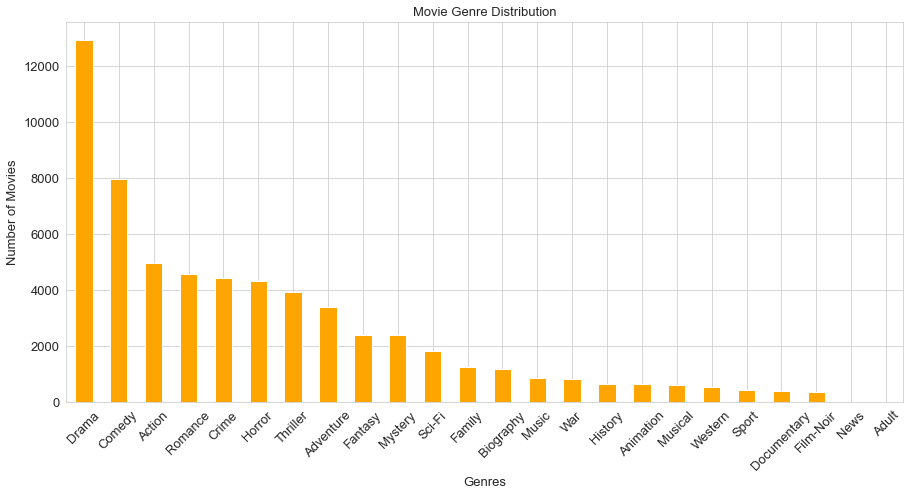

In [59]:
plt.figure(figsize=(15,7))
encoded_genres.sum().sort_values(ascending=False).plot(kind='bar', color='orange')
plt.xlabel('Genres', fontsize=13)
plt.ylabel('Number of Movies', fontsize=13)
plt.title('Movie Genre Distribution', fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('Movie Genre Distribution.png', bbox_inches='tight')
plt.show()

Once more, the "Drama" genre is the most frequently occuring primary genre within our dataset. We can further visualize this below.

This newly encoded dataframe can be merged with the `movies` dataframe and the **genres** column can be removed from it and our list of non-numeric columns.

In [44]:
movies = movies.join(encoded_genres).drop(columns='genres')
movies.head()

,primaryTitle,runtimeMinutes,numVotes,sentiment,review,review_word_count,Action,Adult,Adventure,Animation,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,The Student of Prague,85,2054,1,"A good film, and one I'll watch a number of ti...",172,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Student of Prague,85,2054,1,"In this truly fascinating, dark film, a young ...",292,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Student of Prague,85,2054,1,This early version of the tale 'The Student of...,142,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,The Student of Prague,85,2054,1,Those engaging the movie camera so early in th...,165,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The Student of Prague,85,2054,1,A stupid young man becomes obsessed with a wom...,184,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
movies[movies.isna()]

,primaryTitle,runtimeMinutes,numVotes,sentiment,review,review_word_count,Action,Adult,Adventure,Animation,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
movies.isna().sum()

primaryTitle          0
runtimeMinutes        0
numVotes              0
sentiment             0
review                0
review_word_count     0
Action               40
Adult                40
Adventure            40
Animation            40
Biography            40
Comedy               40
Crime                40
Documentary          40
Drama                40
Family               40
Fantasy              40
Film-Noir            40
History              40
Horror               40
Music                40
Musical              40
Mystery              40
News                 40
Romance              40
Sci-Fi               40
Sport                40
Thriller             40
War                  40
Western              40
dtype: int64

In [47]:
movies.dropna(inplace=True)

In [48]:
categorical_col_list.remove('genres')
categorical_col_list

['primaryTitle', 'review']

___

### `primaryTitle`

While the **primaryTitle** column may not necessarily allow us to gain any insight into what is a factor between a review and the sentiment towards a movie, we will keep it in our dataframe so as to better identify the movie with which reviews and findings are associated.

___

### `review`

We can get an initial impression of the most frequently occurring words prior to applying and cleaning procedures to our reviews list.

In [49]:
vectorizer = CountVectorizer(stop_words='english', max_features=200)
text_df = vectorizer.fit_transform(movies['review'])
text_df.shape

(25049, 200)

In [50]:
df = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=text_df.toarray())
df.head()

,10,acting,action,actor,actors,actually,american,audience,away,bad,...,woman,women,work,world,worst,worth,wrong,year,years,young
0,0,0,1,0,0,0,0,3,0,0,...,0,0,1,0,0,1,0,0,0,0
1,0,0,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [51]:
text_dict = {}

for column in df:
    text_dict[column] = df[column].sum()
    
text_dict

{'10': 4679,
 'acting': 6217,
 'action': 3852,
 'actor': 2479,
 'actors': 4482,
 'actually': 4316,
 'american': 2549,
 'audience': 2463,
 'away': 2941,
 'bad': 8674,
 'beautiful': 2572,
 'believe': 2448,
 'best': 7102,
 'better': 5682,
 'big': 3755,
 'bit': 3174,
 'black': 2244,
 'book': 2507,
 'boring': 1815,
 'br': 107056,
 'cast': 3878,
 'character': 7647,
 'characters': 7490,
 'cinema': 1872,
 'classic': 2096,
 'come': 3300,
 'comedy': 3487,
 'comes': 2635,
 'completely': 2050,
 'couple': 1839,
 'course': 2640,
 'day': 2786,
 'dead': 2020,
 'death': 2327,
 'did': 6423,
 'didn': 4542,
 'different': 2489,
 'director': 5064,
 'does': 6443,
 'doesn': 4740,
 'don': 8965,
 'dvd': 2090,
 'effects': 2259,
 'end': 6073,
 'ending': 2694,
 'enjoy': 1874,
 'especially': 2715,
 'excellent': 2342,
 'face': 1802,
 'fact': 3580,
 'family': 2905,
 'fan': 1891,
 'far': 3128,
 'father': 2181,
 'feel': 3241,
 'film': 46236,
 'films': 8021,
 'friends': 1814,
 'fun': 2766,
 'funny': 4284,
 'gets': 3358,

We can visualize how often these words appear by instantiating a wordcloud where the size of each word correlates directly to how often it appears in our text.

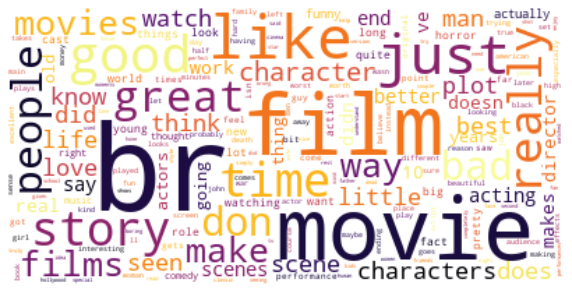

In [62]:
wordcloud = WordCloud(background_color='white',
                     colormap='inferno').generate_from_frequencies(text_dict)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('Wordcloud.png', bbox_inches='tight')
plt.show()

We can see above that there are many words within the wordcloud that will not provide any insight such as "br", "movie", "film" and "good". This gives us an indication as to where to begin when cleaning our reviews and creating a list of stop words to be applied to our vectorization techniques in the next notebook.

That noted, there are still some words that can possibly provide some insight into whether a movie is being classified as "good" or "bad" such as "time", "character", "acting" or "scene". These words indicate what is important to a reviewer when they are leaving their reviews and can be furtehr explored to provide some insight for directors when filming their next movie.

## Conclusion 

At this point in the process, we will proceed with saving our cleaned dataset as cleaning the reviews will be done prior to modeling in the next notebook during vectorization. In the next notebook, we will apply a tokenizer which incorporates basic cleaning on the reviews (i.e. transforming all words to lowercase, removing punctuations, removing common and industry specific stop words). Afterwards, weill will perform machine learning techniques to assess the predictive capability of our sentiment analysis models.

In [53]:
joblib.dump(movies, 'movies.pkl')

['movies.pkl']